In [1]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [2]:
# query =\
# '''
# -- query for clustering v2
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT 
#     user_id, 
#     date_,
#     kyc_tier,
#     loyalty_tier,
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , campaigns AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(date_, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(daily_OTHER_saldo) AS M1_campaign_saldo
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE date_ BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )


# , payments AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     -- TRANSACTIONS
#     COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS M1_core_count,
#     COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS M1_ppob_count,
#     -- CUSTOMER
#     COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS total_customer,
#   FROM `ledger-fcc1e.payment_reports.payments_ssot`
#   WHERE
#     status_v2 = 'COMPLETED'
#     AND transaction_date BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# , accountings AS (
#   SELECT DISTINCT
#     DATE_ADD(DATE_TRUNC(DATE(trans_createdAt), MONTH), INTERVAL 1 MONTH) AS date_,
#     createdByUser AS user_id,
#     COUNT(DISTINCT transactionId) AS M1_acc_count
#   FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
#   WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# -- //this is a bit inefficient since i load the same table twice...
# -- //open to idea on how to do it better
# -- , banks AS (
# --   SELECT DISTINCT
# --     user_id,
# --     date_,
# --     ARRAY_AGG(money_in_channel) OVER(PARTITION BY user_id, date_ ORDER BY cnt_ DESC) [OFFSET(0)] AS main_funding_bank
# --   FROM (
# --     SELECT 
# --       user_id,
# --       DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
# --       money_in_channel,
# --       COUNT(*) AS cnt_
# --     FROM `ledger-fcc1e.payment_reports.payments_ssot`
# --     WHERE
# --       status_v2 = 'COMPLETED'
# --       AND product_type IN ('SALDO')
# --       AND transaction_date BETWEEN '2023-04-01' AND '2023-07-01'
# --     GROUP BY 1, 2, 3
# --   )
# -- )

# , referrals AS (
#   SELECT 
#     referrer AS user_id,
#     date_,
#     COUNT(DISTINCT referee) AS referee_count
#   FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
#   WHERE date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#   GROUP BY 1, 2
# )

# , profiles AS (
#   SELECT DISTINCT
#     user_id,
#     acquisition_channel,
#     user_segment_sub_bucket,
#     first_user_date,
#     first_any_payment_date,
#     first_transaction_date
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_ADD(DATE_TRUNC(notification_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-04-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT DISTINCT
#   user_id,
#   date_,
#   kyc_tier,
#   loyalty_tier,
#   (CASE WHEN M1_core_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_core_count END) AS M1_core_count,
#   (CASE WHEN M1_ppob_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_ppob_count END) AS M1_ppob_count,
#   (CASE WHEN M1_acc_count IS NULL AND date_ >= first_transaction_date THEN 0 ELSE M1_acc_count END) AS M1_acc_count,
#   M1_campaign_saldo,
#   -- (CASE WHEN M1_core_count > 0 THEN 1 ELSE M1_core_count END) AS M1_core_count,
#   -- (CASE WHEN M1_ppob_count > 0 THEN 1 ELSE M1_ppob_count END) AS M1_ppob_count,
#   -- (CASE WHEN M1_acc_count > 0 THEN 1 ELSE M1_acc_count END) AS M1_acc_count,
#   -- (CASE WHEN M1_campaign_saldo > 0 THEN 1 ELSE M1_campaign_saldo END) AS M1_campaign_saldo,
#   total_customer,
#   -- IFNULL(
#   --   IFNULL(
#   --     LAST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
#   --     FIRST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
#   --   ),
#   --   NULL
#   -- ) AS main_funding_bank,
#   (CASE WHEN referee_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
#   acquisition_channel,
#   user_segment_sub_bucket,
#   DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
#   IFNULL(activated_count, 0) AS is_act_m1,
#   IFNULL(converted_count, 0) AS is_conv_m1
# FROM users -- active in last 12 months
# INNER JOIN loyalty USING (user_id) -- needs to be atleast KYC
# LEFT JOIN payments USING (user_id, date_) -- get Q2 transaction data
# -- LEFT JOIN banks USING (user_id, date_)
# LEFT JOIN referrals USING (user_id, date_)
# LEFT JOIN impressions USING (user_id, date_)
# LEFT JOIN accountings USING (user_id, date_)
# LEFT JOIN campaigns USING (user_id, date_)
# LEFT JOIN profiles USING (user_id)
# WHERE date_ < '2023-09-01'
# ORDER BY 1, 2

# '''
# raw = client.query(query).result().to_dataframe()
# raw.to_pickle('data/raw_data_v2.pkl')
raw = pd.read_pickle('data/raw_data_v2.pkl')

# use m1 transaction data
# get profile features which are available to most users
# include more users (who have done kyc and are active in last 12 months)
# check WA impressions and clicks
# in payments_ssot check the bank account when user topup saldo -- main_funding_bank
# can estimate customers as well using payments data
# 


In [3]:
# -- QUERY TO GET IMPRESSIONS COUNT
# imp_query =\
# '''
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT user_id, date_
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_TRUNC(notification_date, MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-05-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT
#   user_id,
#   date_,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
#   IFNULL(activated_count, 0) AS activated_count,
#   IFNULL(converted_count, 0) AS conveted_count
# FROM users
# INNER JOIN loyalty USING (user_id)
# LEFT JOIN impressions USING (user_id, date_)
# WHERE send_count IS NOT NULL
# '''
# imp = client.query(imp_query).result().to_dataframe()
# imp.to_pickle('data/raw_imp_v2.pkl')
imp = pd.read_pickle('data/raw_imp_v2.pkl')

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202898 entries, 0 to 202897
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  202898 non-null  object
 1   date_                    202898 non-null  dbdate
 2   kyc_tier                 202898 non-null  object
 3   loyalty_tier             202898 non-null  object
 4   M1_core_count            148403 non-null  Int64 
 5   M1_ppob_count            148403 non-null  Int64 
 6   M1_acc_count             201373 non-null  Int64 
 7   M1_campaign_saldo        202743 non-null  Int64 
 8   total_customer           87924 non-null   Int64 
 9   is_referrer              202898 non-null  Int64 
 10  acquisition_channel      202898 non-null  object
 11  user_segment_sub_bucket  202898 non-null  object
 12  age_on_platform_days     202898 non-null  Int64 
 13  is_send_m1               202898 non-null  Int64 
 14  is_imp_m1           

In [5]:
std_core = np.std(raw['M1_core_count'])
std_ppob = np.std(raw['M1_ppob_count'])
std_acc = np.std(raw['M1_acc_count'])
std_saldo = np.std(raw['M1_campaign_saldo'])
std_age = np.std(raw['age_on_platform_days'])

df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + " " + x.date_,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        # M1_core_count = lambda x: np.log1p(x.M1_core_count),
        # M1_ppob_count = lambda x: np.log1p(x.M1_ppob_count),
        # M1_acc_count = lambda x: np.log1p(x.M1_acc_count),
        # M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        # age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    .drop(columns=['user_id', 'date_', 'is_send_m1', 'is_imp_m1', 'is_read_m1', 'is_act_m1', 'is_conv_m1', 'M1_campaign_saldo', 'M1_acc_count'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    # .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,kyc_tier,loyalty_tier,M1_core_count,M1_ppob_count,total_customer,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days
index_,,,,,,,,,
1161895687 2023-06-01,ADVANCED,Bronze,0,1,1,0,Organic Acquisition,pureO2O-PA+PP,309
1161895687 2023-07-01,ADVANCED,Bronze,0,2,2,0,Organic Acquisition,pureO2O-PA+PP,339
1161895687 2023-08-01,ADVANCED,Bronze,0,22,16,0,Organic Acquisition,pureO2O-PA+PP,370
8111010474 2023-05-01,ADVANCED,Bronze,0,0,<NA>,0,Paid Acquisition,UNKNOWN,398
8111010474 2023-06-01,ADVANCED,Bronze,0,0,<NA>,0,Paid Acquisition,UNKNOWN,429
...,...,...,...,...,...,...,...,...,...
8999999365 2023-08-01,SUPREME,Gold,0,213,158,0,Offline Acquisition,pureO2O-PAonly,617
8999999557 2023-05-01,SUPREME,Diamond,851,3,437,0,Offline Acquisition,pureO2O-PAonly,469
8999999557 2023-06-01,SUPREME,Diamond,736,0,318,0,Offline Acquisition,pureO2O-PAonly,500


In [6]:
df.describe()

,M1_core_count,M1_ppob_count,total_customer,is_referrer,age_on_platform_days
count,148403.0,148403.0,87924.0,202898.0,202898.0
mean,17.270116,20.826627,38.775988,0.052613,484.595245
std,77.665525,71.568345,88.935877,0.223259,324.605053
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,2.0,0.0,146.0
50%,0.0,0.0,11.0,0.0,514.0
75%,2.0,10.0,38.0,0.0,739.0
max,3731.0,5160.0,2907.0,1.0,1428.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202898 entries, 1161895687 2023-06-01 to 8999999557 2023-08-01
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   kyc_tier                 202898 non-null  object
 1   loyalty_tier             202898 non-null  object
 2   M1_core_count            148403 non-null  Int64 
 3   M1_ppob_count            148403 non-null  Int64 
 4   total_customer           87924 non-null   Int64 
 5   is_referrer              202898 non-null  Int64 
 6   acquisition_channel      202898 non-null  object
 7   user_segment_sub_bucket  202898 non-null  object
 8   age_on_platform_days     202898 non-null  Int64 
dtypes: Int64(5), object(4)
memory usage: 16.4+ MB


In [8]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(202898, 9)"
2,Transformed data shape,"(202898, 26)"
3,Ignore features,1
4,Ordinal features,1
5,Numeric features,5
6,Categorical features,4
7,Rows with missing values,56.7%
8,Preprocess,True
9,Imputation type,simple


In [9]:
kmeans = create_model('kmeans', num_clusters=6)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2094,21228.5942,1.7679,0,0,0


In [10]:
# plot_model(kmeans, 'tsne')

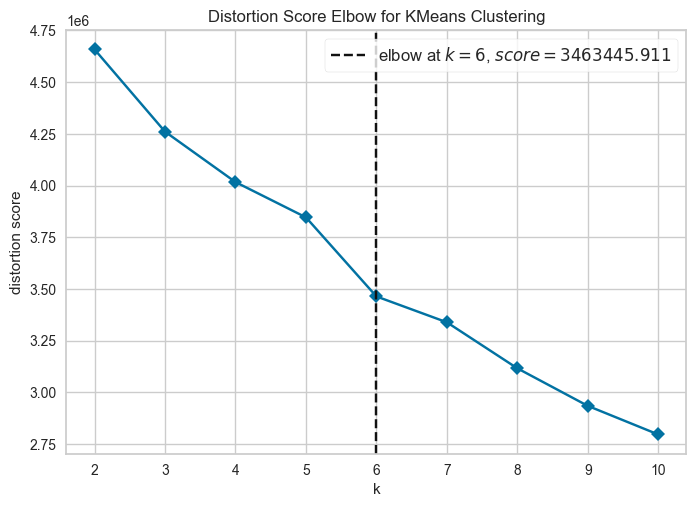

In [11]:
plot_model(kmeans, plot = 'elbow')

In [12]:
# plot_model(kmeans, plot = 'distribution')

In [13]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [14]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84116 entries, 0 to 84115
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            84116 non-null  object
 1   date_              84116 non-null  object
 2   send_count         84116 non-null  Int64 
 3   impressions_count  84116 non-null  Int64 
 4   read_count         84116 non-null  Int64 
 5   activated_count    84116 non-null  Int64 
 6   conveted_count     84116 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 4.9+ MB


In [15]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,conveted_count
count,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.0,0.889878,0.679585,0.411384,0.221313
std,0.0,0.313043,0.466639,0.492088,0.415134
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [16]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split(" ", expand=False).str[0],
        date_ = lambda x: x.index_.str.split(" ", expand=False).str[1]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [17]:
res.describe()

,M1_core_count,M1_ppob_count,total_customer,is_referrer,age_on_platform_days,send_count,impressions_count,read_count,activated_count,conveted_count
count,77672.0,77672.0,62494.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0
mean,26.273187,33.227791,44.31507,0.064138,386.900126,1.0,0.889878,0.679585,0.411384,0.221313
std,96.174458,91.074844,95.818135,0.244999,326.858124,0.0,0.313043,0.466639,0.492088,0.415134
min,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,3.0,0.0,79.0,1.0,1.0,0.0,0.0,0.0
50%,0.0,3.0,13.0,0.0,351.0,1.0,1.0,1.0,0.0,0.0
75%,9.0,29.0,45.0,0.0,639.0,1.0,1.0,1.0,1.0,0.0
max,3731.0,5160.0,2907.0,1.0,1418.0,1.0,1.0,1.0,1.0,1.0


In [18]:
res.groupby([ 'date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  total_customer  \
date_      Cluster                                                   
2023-05-01 Cluster 0      25.933071      64.655231       53.547836   
           Cluster 1       0.211588      13.891271       10.330683   
           Cluster 2        78.8775         110.32      118.296915   
           Cluster 3       4.245346       9.722562       12.042791   
           Cluster 4       0.424649      11.344112        9.169562   
           Cluster 5     342.836795     143.089021      322.828869   
2023-06-01 Cluster 0      20.156984      55.060754       45.202315   
           Cluster 1        0.19138      14.668474        9.496768   
           Cluster 2      73.699084      94.773784       99.746429   
           Cluster 3       3.042126       6.873502       10.275214   
           Cluster 4       0.603918       11.96678           9.225   
           Cluster 5     233.329238     184.305897      251.468905   
2023-07-01 Cluster 0      21.775735      41.157826       38.664868   
           Cluster 1       0.332014      13.392875        8.902625   
           Cluster 2       59.84914      78.655862       82.405022   
           Cluster 3       2.394146        5.15671        9.986953   
           Cluster 4       1.037975       9.814873        8.265925   
           Cluster 5     238.950199     181.217795      249.740027   
2023-08-01 Cluster 0      19.956887      45.571591       40.603136   
           Cluster 1       0.140874      15.530169        9.489499   
           Cluster 2      62.594268      84.051659       88.749513   
           Cluster 3       4.195397      12.303431       12.498409   
           Cluster 4       0.587139      12.049394        9.079906   
           Cluster 5     260.006472     188.126861      266.370999   

                      is_referrer  age_on_platform_days  send_count  \
date_      Cluster                                                    
2023-05-01 Cluster 0     0.077615            343.708661         1.0   
           Cluster 1     0.032187            381.882712         1.0   
           Cluster 2      0.13625             359.67375         1.0   
           Cluster 3     0.027709            266.561866         1.0   
           Cluster 4     0.045866            552.392275         1.0   
           Cluster 5     0.316024            528.473294         1.0   
2023-06-01 Cluster 0     0.074945            355.149002         1.0   
           Cluster 1     0.016635            336.614926         1.0   
           Cluster 2     0.139535            417.776603         1.0   
           Cluster 3     0.026767            271.968068         1.0   
           Cluster 4     0.037845            577.864015         1.0   
           Cluster 5     0.273956            512.078624         1.0   
2023-07-01 Cluster 0     0.095326            465.789916         1.0   
           Cluster 1     0.034889            371.420792         1.0   
           Cluster 2     0.152461            511.188876         1.0   
           Cluster 3     0.038659            351.470866         1.0   
           Cluster 4     0.056338            604.758216         1.0   
           Cluster 5     0.252988            540.522576         1.0   
2023-08-01 Cluster 0     0.098934            501.040617         1.0   
           Cluster 1     0.034742            372.823129         1.0   
           Cluster 2     0.158748            529.726621         1.0   
           Cluster 3     0.042436            318.513261         1.0   
           Cluster 4     0.059415            644.714808         1.0   
           Cluster 5      0.26343            571.539159         1.0   

                      impressions_count  read_count  activated_count  \
date_      Cluster                                                     
2023-05-01 Cluster 0           0.903825    0.770529          0.77784   
           Cluster 1           0.897098    0.715679         0.470129   
           Cluster 2             0.8875      0.7575          0.816

In [19]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  M1_core_count  M1_ppob_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0      1778          1778           1778           1778   
           Cluster 1      4101          4101           3918           3918   
           Cluster 2       800           800            800            800   
           Cluster 3      7290          7290           7198           7198   
           Cluster 4      1657          1657           1639           1639   
           Cluster 5       674           674            674            674   
2023-06-01 Cluster 0      2255          2255           2255           2255   
           Cluster 1      8897          8897           3689           3689   
           Cluster 2      1419          1419           1419           1419   
           Cluster 3      8518          8518           8427           8427   
           Cluster 4      1559          1559           1174           1174   
           Cluster 5       814           814            814            814   
2023-07-01 Cluster 0      3808          3808           3808           3808   
           Cluster 1      4242          4242           4042           4042   
           Cluster 2      2499          2499           2499           2499   
           Cluster 3     12494         12494          12437          12437   
           Cluster 4      1278          1278           1264           1264   
           Cluster 5      1506          1506           1506           1506   
2023-08-01 Cluster 0      4407          4407           4407           4407   
           Cluster 1      4116          4116           3961           3961   
           Cluster 2      2652          2652           2652           2652   
           Cluster 3      4713          4713           4693           4693   
           Cluster 4      1094          1094           1073           1073   
           Cluster 5      1545          1545           1545           1545   

                      total_customer  is_referrer  acquisition_channel  \
date_      Cluster                                                       
2023-05-01 Cluster 0            1756         1778                 1778   
           Cluster 1            3018         4101                 4101   
           Cluster 2             778          800                  800   
           Cluster 3            5632         7290                 7290   
           Cluster 4            1209         1657                 1657   
           Cluster 5             672          674                  674   
2023-06-01 Cluster 0            2160         2255                 2255   
           Cluster 1            3249         8897                 8897   
           Cluster 2            1400         1419                 1419   
           Cluster 3            5483         8518                 8518   
           Cluster 4             920         1559                 1559   
           Cluster 5             804          814                  814   
2023-07-01 Cluster 0            3706         3808                 3808   
           Cluster 1            3543         4242                 4242   
           Cluster 2            2469         2499                 2499   
           Cluster 3            6515        12494                12494   
           Cluster 4             989         1278                 1278   
           Cluster 5            1504         1506                 1506   
2023-08-01 Cluster 0            4082         4407                 4407   
           Cluster 1            3571         4116                 4116   
           Cluster 2            2567         2652                 2652   
           Cluster 3            4085         4713                 4713   
           Cluster 4             851         1094                 1094   
           Cluster 5            1531         1545                 1545   

                      user_segment_sub_bucket  age_on_platform_days 